<a href="https://colab.research.google.com/github/Lucazere00/music_emotion_recognition/blob/main/music_emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installazione delle librerie**

In [4]:
!pip install librosa --upgrade
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow

!git clone https://github.com/Lucazere00/music_emotion_recognition.git

Cloning into 'music_emotion_recognition'...
remote: Enumerating objects: 7245, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7245 (delta 1), reused 0 (delta 0), pack-reused 7239 (from 2)
Receiving objects: 100% (7245/7245), 1.88 GiB | 16.77 MiB/s, done.
Resolving deltas: 100% (95/95), done.


# **Import**

In [5]:
import seaborn as sns
import pandas as pd
from datetime import datetime
import os
import numpy as np
from google.colab import drive
import librosa
import librosa.display
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# **Dataset**

In [7]:
import kagglehub

path = kagglehub.dataset_download("imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music")

print("Path to dataset files:", path)

Resuming download from 1620049920 bytes (347118821 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music?dataset_version_number=1 (1620049920/1967168741) bytes left.


100%|██████████| 1.83G/1.83G [00:16<00:00, 21.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1


In [8]:
dataset_path = '/root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1'
print(os.listdir(dataset_path))

audio_dir = os.path.join(dataset_path, 'DEAM_audio', 'MEMD_audio')
annotations_dir = os.path.join(dataset_path, 'DEAM_Annotations', 'annotations',
                          'annotations averaged per song', 'song_level',
                          'static_annotations_averaged_songs_1_2000.csv')

# verifico i paths
print("Audio Directory Path:", audio_dir)
print("Static CSV Path:", annotations_dir)

# verifico se i paths esistono
if os.path.exists(audio_dir):
    print("Audio directory exists.")
else:
    print("Audio directory does not exist!")

if os.path.exists(annotations_dir):
    print("Static CSV file exists.")
else:
    print("Static CSV file does not exist!")

['features', 'DEAM_Annotations', 'DEAM_audio']
Audio Directory Path: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_audio/MEMD_audio
Static CSV Path: /root/.cache/kagglehub/datasets/imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music/versions/1/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv
Audio directory exists.
Static CSV file exists.


# **Breve EDA (Exploratory data analysis)**

In [9]:

# genero il dataframe pandas
annotations_df = pd.read_csv(annotations_dir)

# le prime istanze
print("Dataset Preview:")
print(annotations_df.head())

# informazioni
print("\nDataset Info:")
print(annotations_df.info())

# statistiche
print("\nSummary Statistics:")
print(annotations_df.describe())

Dataset Preview:
   song_id   valence_mean   valence_std   arousal_mean   arousal_std
0        2            3.1          0.94            3.0          0.63
1        3            3.5          1.75            3.3          1.62
2        4            5.7          1.42            5.5          1.63
3        5            4.4          2.01            5.3          1.85
4        7            5.8          1.47            6.4          1.69

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1    valence_mean  1744 non-null   float64
 2    valence_std   1744 non-null   float64
 3    arousal_mean  1744 non-null   float64
 4    arousal_std   1744 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 68.3 KB
None

Summary Statistics:
           song_id   valence_mean   valence_std   arousal_mean 

In [10]:
# verifico se ci sono valori nulli
print(annotations_df.isna().sum())

song_id          0
 valence_mean    0
 valence_std     0
 arousal_mean    0
 arousal_std     0
dtype: int64


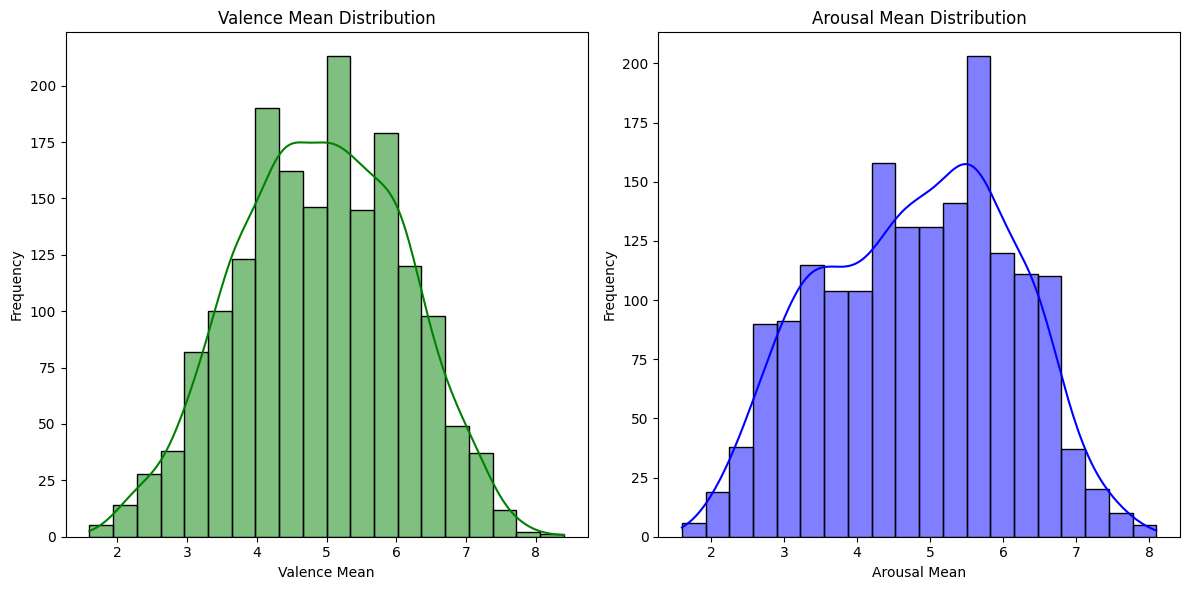

In [11]:
plt.figure(figsize=(12, 6))

annotations_df.columns = annotations_df.columns.str.strip()

# distribuzione valence_mean
plt.subplot(1, 2, 1)
sns.histplot(annotations_df['valence_mean'], kde=True, color='green', bins=20)
plt.title('Valence Mean Distribution')
plt.xlabel('Valence Mean')
plt.ylabel('Frequency')

# # distribuzione arousal_mean
plt.subplot(1, 2, 2)
sns.histplot(annotations_df['arousal_mean'], kde=True, color='blue', bins=20)
plt.title('Arousal Mean Distribution')
plt.xlabel('Arousal Mean')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# **Costruisco le classi emozionali**

In [12]:
v_low, v_high = annotations_df['valence_mean'].quantile([0.33, 0.66])
a_low, a_high = annotations_df['arousal_mean'].quantile([0.33, 0.66])

def classes(row):
    v, a = row['valence_mean'], row['arousal_mean']

    if v >= v_high and a >= a_high:
        return 'Happy'
    elif v <= v_low and a >= a_high:
        return 'Angry'
    elif v <= v_low and a <= a_low:
        return 'Sad'
    elif v >= v_high and a <= a_low:
        return 'Relaxed'
    else:
        return 'Neutral'

annotations_df['label'] = annotations_df.apply(classes, axis=1)
print(annotations_df[['song_id', 'valence_mean', 'arousal_mean', 'label']].head(10))

print(annotations_df['label'].value_counts())

   song_id  valence_mean  arousal_mean    label
0        2           3.1           3.0      Sad
1        3           3.5           3.3      Sad
2        4           5.7           5.5    Happy
3        5           4.4           5.3  Neutral
4        7           5.8           6.4    Happy
5        8           3.2           4.8  Neutral
6       10           4.0           4.7  Neutral
7       12           5.5           5.8    Happy
8       13           3.2           4.0      Sad
9       17           4.4           6.0  Neutral
label
Neutral    881
Happy      385
Sad        367
Angry       59
Relaxed     52
Name: count, dtype: int64


In [13]:
annotations_df = annotations_df[annotations_df['label'] != 'Neutral']

In [14]:
print(annotations_df['label'].value_counts())


label
Happy      385
Sad        367
Angry       59
Relaxed     52
Name: count, dtype: int64


# **Estrazione del Mel-Spectrogram**

In [15]:
def extract_mel_segment(file_path, start_sec, duration=5, n_mels=128, max_len=256):
    # Carichiamo solo il segmento che ci interessa (offset e duration)
    y, sr = librosa.load(file_path, sr=22050, offset=start_sec, duration=duration)

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Normalizzazione tra 0 e 1 (aiuta molto la CNN a convergere)
    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)

    # Padding/Cropping per assicurare che la larghezza sia max_len
    if mel_db.shape[1] < max_len:
        pad_width = max_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mel_db = mel_db[:, :max_len]

    return mel_db

In [16]:
from tqdm import tqdm

X = []
y = []

# 5 segmenti da 5 secondi per TUTTI
segments = [(i * 6, 5) for i in range(5)]

for _, row in tqdm(annotations_df.iterrows(),
                   total=len(annotations_df),
                   desc="Estrazione Spettrogrammi"):

    file_path = os.path.join(audio_dir, f"{int(row['song_id'])}.mp3")
    label = row['label']

    if not os.path.exists(file_path):
        continue

    for start, dur in segments:
        try:
            mel_spec = extract_mel_segment(
                file_path,
                start_sec=start,
                duration=dur,
                max_len=256
            )
            X.append(mel_spec)
            y.append(label)

        except Exception:
            continue



Estrazione Spettrogrammi: 100%|██████████| 863/863 [02:20<00:00,  6.15it/s]


# **Preprocessing e codifica**

In [17]:
X = np.array(X)[..., np.newaxis]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print("Classi mappate:", label_encoder.classes_)
print("Forma X:", X.shape) # Dovrebbe essere (N_Campioni, 128, 256, 1)

Classi mappate: ['Angry' 'Happy' 'Relaxed' 'Sad']
Forma X: (4315, 128, 256, 1)


In [18]:
from collections import Counter
print(Counter(y))

Counter({'Happy': 1925, 'Sad': 1835, 'Angry': 295, 'Relaxed': 260})


In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(3.656779661016949), 1: np.float64(0.5603896103896104), 2: np.float64(4.149038461538462), 3: np.float64(0.587874659400545)}


In [26]:
from sklearn.model_selection import GroupShuffleSplit

# groups = id delle canzoni ripetuto se necessario
groups = annotations_df['song_id'].values.repeat(5)

# Primo split: creiamo test set (ad esempio 10% del dataset)
gss_test = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_val_idx, test_idx = next(gss_test.split(X, y_categorical, groups))

X_train_val, X_test = X[train_val_idx], X[test_idx]
y_train_val, y_test = y_categorical[train_val_idx], y_categorical[test_idx]



# **Definizione della rete neurale CNN**

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    # Cambiato input_shape a 256 di larghezza
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 256, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Aggiungiamo un terzo blocco per gestire la complessità dell'audio
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), # Aumentato leggermente per gestire il rumore delle label
    Dense(4, activation='softmax') # Assicurati che CLASSES siano 4
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 127, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 125, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 125, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 53760)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,881,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,975,492 (26.61 MB)

 Trainable params: 6,975,044 (26.61 MB)

 Non-trainable params: 448 (1.75 KB)

# **Addestramento del modello**

In [23]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.5733 - loss: 6.9236 - val_accuracy: 0.0578 - val_loss: 68.4281
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.6234 - loss: 1.2461 - val_accuracy: 0.4578 - val_loss: 12.5739
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.6484 - loss: 1.1289 - val_accuracy: 0.4000 - val_loss: 14.2124
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.6627 - loss: 1.0727 - val_accuracy: 0.4370 - val_loss: 5.3786
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7009 - loss: 0.9644 - val_accuracy: 0.5526 - val_loss: 2.5984
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7112 - loss: 0.9759 - val_accuracy: 0.7214 - val_loss: 0.9386
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7143 - loss: 0.9335 - val_accuracy: 0.6439 - val_loss: 1.0383
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7400 - loss: 0.8707 - va

# **Valutazione**

In [24]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy sul test set: {accuracy:.2f}')

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7845 - loss: 0.7203
Accuracy sul test set: 0.77


# **Visualizzazione andamento**

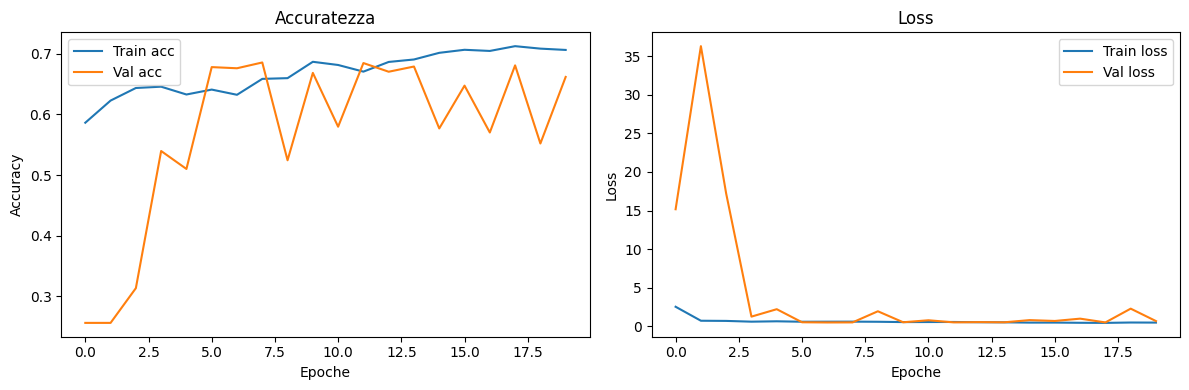

In [ ]:
plt.figure(figsize=(12, 4))

#con plt.plot(...) mostriamo accuracy e loss nel tempo

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Accuratezza')
plt.xlabel('Epoche')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()

# Salvo la figura in Drive
plt.tight_layout()
plt.show()

# **Salvataggio del modello addestrato**

In [ ]:
model.save('music_emotion_recognition_model.h5')

In [15]:
from tensorflow.keras.models import load_model

model = load_model('/content/music_emotion_recognition/music_emotion_recognition_model.h5')

# **Visualizzazione di alcuni Mel-Spectrogram**

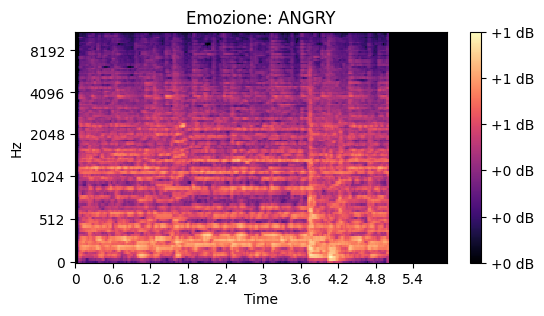

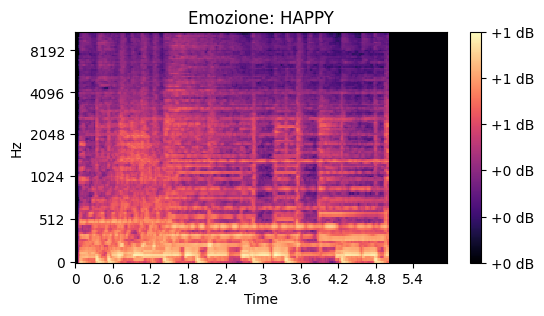

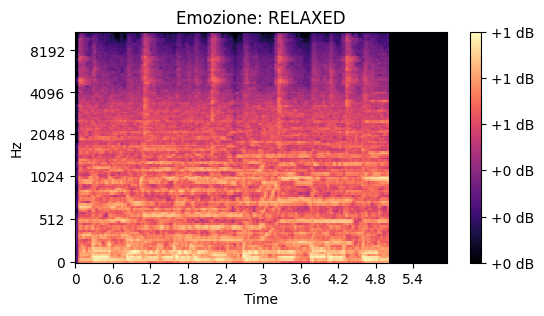

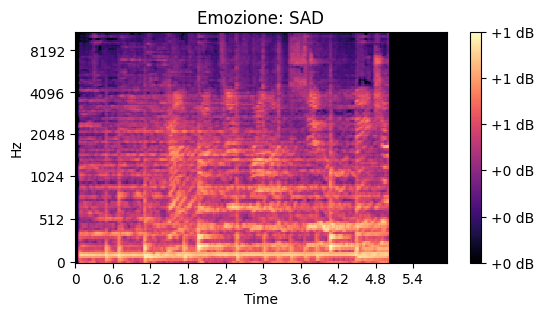

In [25]:
# Ciclo per ogni numero di classe (0, 1, 2, 3...)
for i in range(len(label_encoder.classes_)):

    # Troviamo la prima posizione dove l'etichetta è uguale a i
    indice = np.where(y_encoded == i)[0][0]

    # Creiamo il grafico
    plt.figure(figsize=(6, 3))

    # Mostriamo lo spettrogramma (prendiamo il primo canale [:,:,0])
    librosa.display.specshow(X[indice][:,:,0], x_axis='time', y_axis='mel')

    # Aggiungiamo titolo (nome emozione) e barra del colore
    plt.title(f"Emozione: {label_encoder.classes_[i].upper()}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# **Confronto tra Mel-Spectrogram e MFCC**

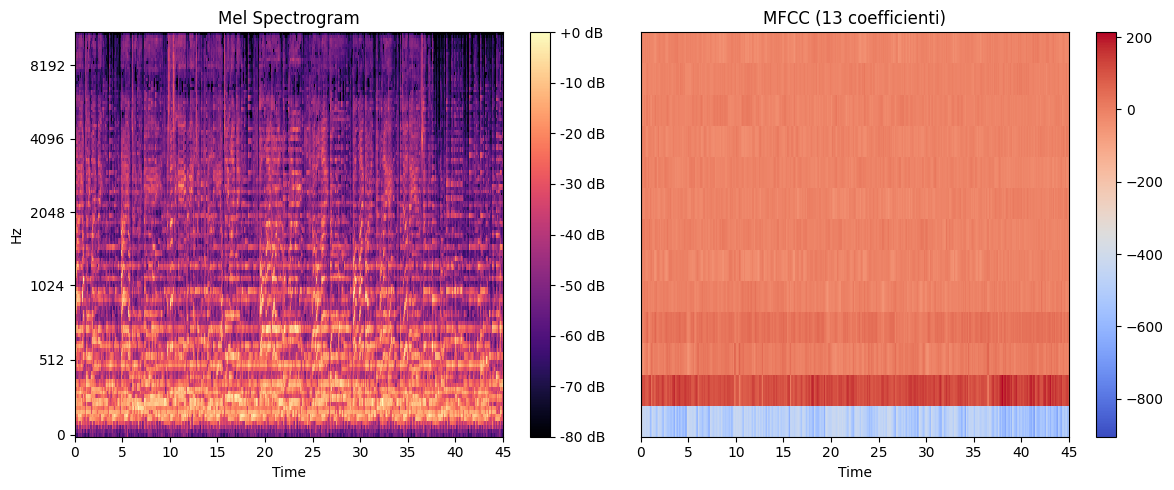

In [16]:
label_encoder_classes = label_encoder.classes_

# Find a song_id for the first class (e.g., 'Angry')
sample_class_label = label_encoder_classes[0] # e.g., 'Angry'
sample_song_id = annotations_df[annotations_df['label'] == sample_class_label]['song_id'].iloc[0]

file_path = os.path.join(audio_dir, f"{int(sample_song_id)}.mp3")
y, sr = librosa.load(file_path)

# Mel Spectrogram
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
mel_db = librosa.power_to_db(mel, ref=np.max)

# MFCC
mfcc = librosa.feature.mfcc(S=mel_db, sr=sr, n_mfcc=13)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
librosa.display.specshow(mel_db, x_axis='time', y_axis='mel', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')

plt.subplot(1, 2, 2)
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC (13 coefficienti)')

plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/Progetto_Artificial_Intelligence/Mel-MFCC.png')
plt.show()

# **Confusion Matrix**

33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 679ms/step


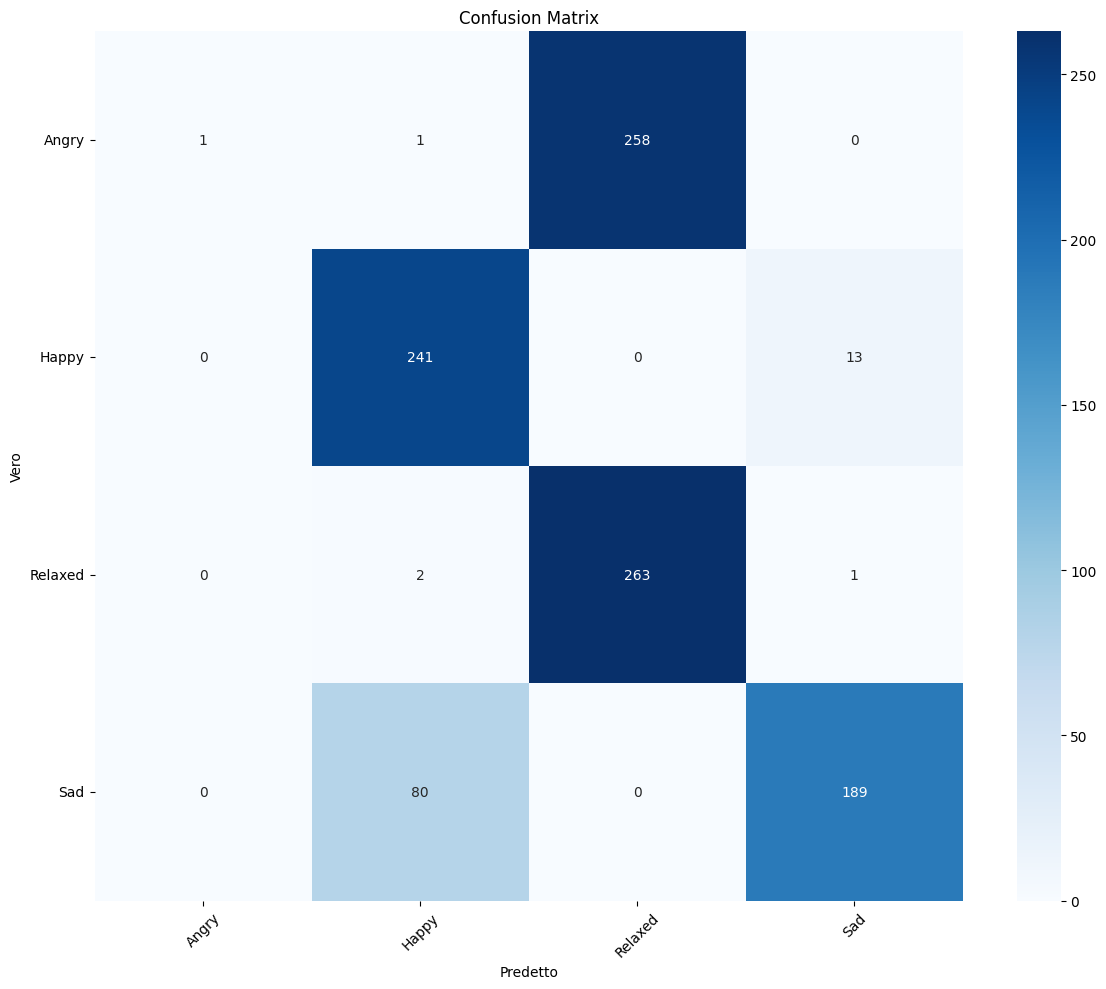

In [17]:
# Otteniamo le predizioni del modello
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcolo e visualizzazione della confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel("Predetto")
plt.ylabel("Vero")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/music_emotion_recognition/confusion_matrix_plot1.png')
plt.show()